In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.models import densenet121
import numpy as np

In [2]:
# Step 1: Data Transformation and Loading for CIFAR-10 (with smaller image size)
transform = transforms.Compose([
    transforms.Resize(128),  # Resize to 128x128 to reduce memory usage
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training dataset into train and validation sets (e.g., 80% train, 20% val)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Reduced batch size
valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Step 2: Define Fine-tuned DenseNet Model with Dropout
class DenseNet_Finetune(nn.Module):
    def __init__(self, num_classes=10):
        super(DenseNet_Finetune, self).__init__()
        self.densenet = densenet121(pretrained=True)
        # Modify the classifier for CIFAR-10 classes
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Add dropout for regularization
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.densenet(x)

In [4]:
# Step 3: Model, Loss Function, Optimizer, and Learning Rate Scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNet_Finetune(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR on plateau

# Early stopping criteria
early_stopping_patience = 3
best_val_loss = np.inf
patience_counter = 0

C:\Users\Stewie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Stewie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Step 4: Training and Validation Function with Early Stopping
def train_and_validate(model, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    global best_val_loss, patience_counter

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch_idx, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Print per-batch results for training
            # print(f"  Batch {batch_idx + 1}/{len(trainloader)} - Loss: {loss.item():.4f}, "
                #   f"Acc: {100 * correct / total:.2f}%")

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(valloader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Print per-batch results for validation
                # print(f"  Validation Batch {batch_idx + 1}/{len(valloader)} - Loss: {loss.item():.4f}, "f"Acc: {100 * correct / total:.2f}%")
        
        val_loss /= len(valloader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Adjust learning rate
        scheduler.step()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

        print(f'Epoch {epoch + 1}/{num_epochs} Summary - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [6]:
# Step 5: Train and Validate the Model
num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=num_epochs
)


Epoch 1/20
Epoch 1/20 Summary - Train Loss: 0.4739, Train Acc: 84.50%, Val Loss: 0.2048, Val Acc: 93.48%

Epoch 2/20
Epoch 2/20 Summary - Train Loss: 0.2056, Train Acc: 93.20%, Val Loss: 0.1662, Val Acc: 94.46%

Epoch 3/20
Epoch 3/20 Summary - Train Loss: 0.1549, Train Acc: 94.92%, Val Loss: 0.1532, Val Acc: 94.84%

Epoch 4/20
Epoch 4/20 Summary - Train Loss: 0.1257, Train Acc: 95.83%, Val Loss: 0.1559, Val Acc: 94.97%

Epoch 5/20
Epoch 5/20 Summary - Train Loss: 0.1016, Train Acc: 96.68%, Val Loss: 0.1597, Val Acc: 94.64%

Epoch 6/20
Epoch 6/20 Summary - Train Loss: 0.0552, Train Acc: 98.17%, Val Loss: 0.1271, Val Acc: 96.01%

Epoch 7/20
Epoch 7/20 Summary - Train Loss: 0.0384, Train Acc: 98.78%, Val Loss: 0.1441, Val Acc: 95.71%

Epoch 8/20
Epoch 8/20 Summary - Train Loss: 0.0342, Train Acc: 98.86%, Val Loss: 0.1356, Val Acc: 96.01%

Epoch 9/20
Early stopping triggered.


In [7]:

# Step 6: Test the Model
def test(model, testloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Run test after training and validation
test_accuracy = test(model, testloader)
print(f'Final Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 95.82%
Final Test Accuracy: 95.82%


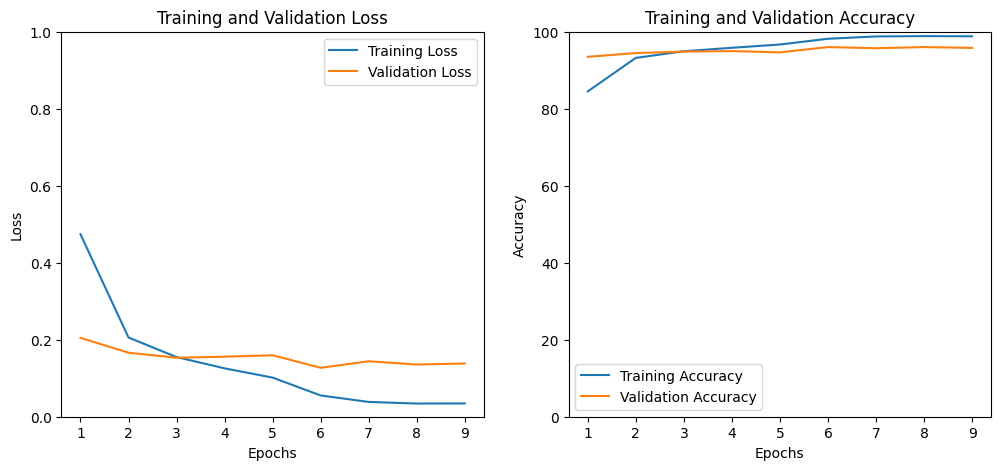

In [8]:
# Plot Training/Validation Accuracy and Loss Curves
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,100)
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()
